# Imports

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import copy

# Global Variables

In [10]:
epochs = 500
batch_size = 16
number_of_particles = epochs * 2 * batch_size
dt = 0.1

# Classes

In [11]:
class Particle:
    def __str__(self):
        return "Position: %s, Velocity: %s, Accleration: %s" % (self.position, self.velocity, self.acceleration)
    
    def __repr__(self):
        return "Position: %s, Velocity: %s, Accleration: %s" % (self.position, self.velocity, self.acceleration)
    
    def __init__(self):
        self.position = np.array([np.random.sample()*2-1,np.random.sample()*2-1]) # Position X, Y
        self.velocity = np.array([np.random.sample()*2-1,np.random.sample()*2-1]) # Velocity X, Y
        self.acceleration = np.array([np.random.sample()*2-1,np.random.sample()*2-1]) # Acceleration X, Y
        
    def apply_physics(self,dt):
        nextParticle = copy.deepcopy(self) # Copy to retain initial values
        nextParticle.position += self.velocity * dt
        nextParticle.velocity += self.acceleration * dt
        return nextParticle
    
    def get_list(self):
        return [self.position[0],self.position[1],self.velocity[0], self.velocity[1], self.acceleration[0], self.acceleration[1]]
    
    def get_list_physics(self,dt):
        n = self.apply_physics(dt)
        return [self.position[0],self.position[1],self.velocity[0], self.velocity[1], self.acceleration[0], 
                self.acceleration[1], n.position[0], n.position[1], n.velocity[0], n.velocity[1]]

In [12]:
class GAN:
    def __init__(self,input_size,output_size,dropout=0.4):
        self.input_size = input_size
        self.output_size = output_size
        self.dropout = dropout
        self.generator = self.generator_network()
        self.discriminator = self.discriminator_network()
        self.adverserial = self.adverserial_network()
    
    def discriminator_trainable(self, val):
        self.discriminator.trainable = val
        for l in self.discriminator.layers:
            l.trainable = val
    
    def generator_network(self): # Generator : Object(6) - Dense - Object(4)
        self.g_input = Input(shape=(self.input_size,), name="Generator_Input")
        g = Dense(128, activation='relu')(self.g_input)
        g = Dropout(self.dropout)(g)
        g = Dense(256, activation='relu')(g)
        g = Dropout(self.dropout)(g)
        g = Dense(512, activation='relu')(g)
        g = Dropout(self.dropout)(g)
        g = Dense(256, activation='relu')(g)
        g = Dropout(self.dropout)(g)
        g = Dense(128, activation='relu')(self.g_input)
        g = Dropout(self.dropout)(g)
        self.g_output = Dense(self.output_size, activation='tanh', name="Generator_Output")(g) 
        m = Model(self.g_input, self.g_output, name="Generator")
        return m
    
    def discriminator_network(self): # Discriminator : Object(10) - Dense - Probability
        d_opt = RMSprop(lr=0.0002,decay=6e-8)
        d_input = Input(shape=(self.input_size+self.output_size,), name="Discriminator_Input")
        d = Dense(128, activation='relu')(d_input)
        d = Dense(256, activation='relu')(d)
        d = Dense(512, activation='relu')(d)
        d = Dense(256, activation='relu')(d)
        d = Dense(128, activation='relu')(d)
        d_output = Dense(1, activation='sigmoid', name="Discriminator_Output")(d)
        m = Model(d_input, d_output, name="Discriminator")
        m.compile(loss='binary_crossentropy', optimizer=d_opt)
        return m
    
    def adverserial_network(self): # Adverserial : Object(6) - Generator - Discriminator - Probability
        a_opt = RMSprop(lr=0.0001,decay=3e-8)
        d_input = Concatenate(name="Generator_Input_Output")([self.g_input,self.g_output])
        m=Model(self.g_input, self.discriminator(d_input))
        m.compile(loss='binary_crossentropy', optimizer=a_opt)
        return m
    
    def train_discriminator(self,val):
        self.discriminator.trainable = val
        for l in self.discriminator.layers:
            l.trainable = val
    
    def train(self, adverserial_set, discriminator_set, epochs, batch_size):
        
        losses = {"d":[], "g":[]}

        for i in range(epochs):
            
            batch = discriminator_set[int(i/2*batch_size/2):int((i/2+1)*batch_size/2)] # Gets a batch of real data
            
            for j in adverserial_set[int(i/2*batch_size/2):int((i/2+1)*batch_size/2)]: # Gets a batch of generated data
                n = copy.deepcopy(j)
                p = self.predict(j)
                for e in p:
                    n.append(e)
                batch.append(n)
            
            #self.train_discriminator(True) # Turns on discriminator weights
            
            output = np.zeros(batch_size) # Sets output weight 0 for real and 1 for fakes
            output[int(batch_size/2):] = 1
            
            losses["d"].append(self.discriminator.train_on_batch(np.array(batch), np.array(output))) # Train discriminator
            
            batch = adverserial_set[(i*batch_size):((i+1)*batch_size)] # Gets real data to train generator
            output = np.zeros(batch_size)
            
            #self.train_discriminator(False) # Turns off discriminator weights
            
            losses["g"].append(self.adverserial.train_on_batch(np.array(batch), np.array(output))) # Train generator
            
            print('Epoch %s - Adverserial Loss : %s, Discriminator Loss : %s' % (i+1, losses["g"][-1], losses["d"][-1]))
        
        self.generator.save("Generator.h5")
        self.discriminator.save("Discriminator.h5")
        
        return losses
    
    def predict(self, pred):
        return self.generator.predict(np.array(pred).reshape(-1,6))[0]

# Training Data

In [13]:
training_set = []
actual_set = []

for i in range(number_of_particles):
    p = Particle()
    if(i%2==0):
        training_set.append(p.get_list())
    else:
        actual_set.append(p.get_list_physics(dt))

# Training

In [14]:
network = GAN(input_size=6,output_size=4,dropout=0)

In [15]:
loss = network.train(adverserial_set=training_set,discriminator_set=actual_set,epochs=epochs,batch_size=batch_size)

Epoch 1 - Adverserial Loss : 0.7593789, Discriminator Loss : 0.7475223
Epoch 2 - Adverserial Loss : 0.7363486, Discriminator Loss : 0.7152627
Epoch 3 - Adverserial Loss : 0.75299, Discriminator Loss : 0.7028278
Epoch 4 - Adverserial Loss : 0.73692214, Discriminator Loss : 0.7308773
Epoch 5 - Adverserial Loss : 0.72971106, Discriminator Loss : 0.7396294
Epoch 6 - Adverserial Loss : 0.7399001, Discriminator Loss : 0.7159431
Epoch 7 - Adverserial Loss : 0.7122102, Discriminator Loss : 0.72455233
Epoch 8 - Adverserial Loss : 0.67741907, Discriminator Loss : 0.7300263
Epoch 9 - Adverserial Loss : 0.69089687, Discriminator Loss : 0.6907587
Epoch 10 - Adverserial Loss : 0.7400292, Discriminator Loss : 0.6808979
Epoch 11 - Adverserial Loss : 0.6905575, Discriminator Loss : 0.72096413
Epoch 12 - Adverserial Loss : 0.7430903, Discriminator Loss : 0.7067504
Epoch 13 - Adverserial Loss : 0.693717, Discriminator Loss : 0.67834234
Epoch 14 - Adverserial Loss : 0.71504897, Discriminator Loss : 0.6904

Epoch 228 - Adverserial Loss : 0.6077394, Discriminator Loss : 0.68140525
Epoch 229 - Adverserial Loss : 0.6139508, Discriminator Loss : 0.68398386
Epoch 230 - Adverserial Loss : 0.5919621, Discriminator Loss : 0.67471707
Epoch 231 - Adverserial Loss : 0.6711421, Discriminator Loss : 0.6674968
Epoch 232 - Adverserial Loss : 0.62290376, Discriminator Loss : 0.6779352
Epoch 233 - Adverserial Loss : 0.65000093, Discriminator Loss : 0.6825742
Epoch 234 - Adverserial Loss : 0.61738294, Discriminator Loss : 0.6819666
Epoch 235 - Adverserial Loss : 0.6063523, Discriminator Loss : 0.7291107
Epoch 236 - Adverserial Loss : 0.59917426, Discriminator Loss : 0.7027683
Epoch 237 - Adverserial Loss : 0.612478, Discriminator Loss : 0.6580717
Epoch 238 - Adverserial Loss : 0.58863866, Discriminator Loss : 0.6619445
Epoch 239 - Adverserial Loss : 0.63860035, Discriminator Loss : 0.6787542
Epoch 240 - Adverserial Loss : 0.6128602, Discriminator Loss : 0.6975331
Epoch 241 - Adverserial Loss : 0.6376193, D

Epoch 341 - Adverserial Loss : 0.6227477, Discriminator Loss : 0.68034446
Epoch 342 - Adverserial Loss : 0.6226987, Discriminator Loss : 0.6933929
Epoch 343 - Adverserial Loss : 0.58960927, Discriminator Loss : 0.72929925
Epoch 344 - Adverserial Loss : 0.63713336, Discriminator Loss : 0.7309754
Epoch 345 - Adverserial Loss : 0.5902475, Discriminator Loss : 0.71100175
Epoch 346 - Adverserial Loss : 0.5998826, Discriminator Loss : 0.6775486
Epoch 347 - Adverserial Loss : 0.58342975, Discriminator Loss : 0.68644655
Epoch 348 - Adverserial Loss : 0.5721493, Discriminator Loss : 0.6912506
Epoch 349 - Adverserial Loss : 0.5894454, Discriminator Loss : 0.7082455
Epoch 350 - Adverserial Loss : 0.5870169, Discriminator Loss : 0.69657516
Epoch 351 - Adverserial Loss : 0.5903653, Discriminator Loss : 0.6323681
Epoch 352 - Adverserial Loss : 0.606125, Discriminator Loss : 0.6444925
Epoch 353 - Adverserial Loss : 0.6099578, Discriminator Loss : 0.6838844
Epoch 354 - Adverserial Loss : 0.6057604, Di

Epoch 453 - Adverserial Loss : 0.6031664, Discriminator Loss : 0.689811
Epoch 454 - Adverserial Loss : 0.5507154, Discriminator Loss : 0.658049
Epoch 455 - Adverserial Loss : 0.56434613, Discriminator Loss : 0.74016273
Epoch 456 - Adverserial Loss : 0.56368345, Discriminator Loss : 0.77675605
Epoch 457 - Adverserial Loss : 0.5559895, Discriminator Loss : 0.66117585
Epoch 458 - Adverserial Loss : 0.5644894, Discriminator Loss : 0.6528442
Epoch 459 - Adverserial Loss : 0.54982615, Discriminator Loss : 0.71134794
Epoch 460 - Adverserial Loss : 0.5696553, Discriminator Loss : 0.7114428
Epoch 461 - Adverserial Loss : 0.5278839, Discriminator Loss : 0.6748923
Epoch 462 - Adverserial Loss : 0.57039356, Discriminator Loss : 0.6626449
Epoch 463 - Adverserial Loss : 0.5518574, Discriminator Loss : 0.67515355
Epoch 464 - Adverserial Loss : 0.58958757, Discriminator Loss : 0.701882
Epoch 465 - Adverserial Loss : 0.55770606, Discriminator Loss : 0.7238263
Epoch 466 - Adverserial Loss : 0.60028404, 

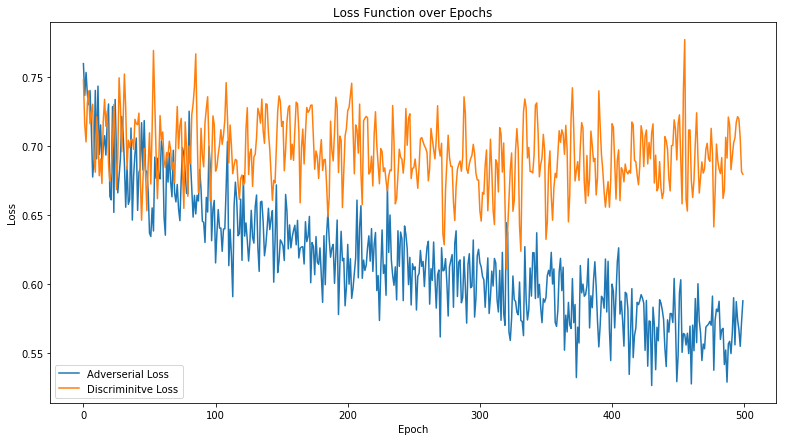

In [16]:
fig = plt.figure(figsize=(13,7))
plt.title("Loss Function over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(loss["g"], label="Adverserial Loss")
plt.plot(loss["d"], label="Discriminitve Loss")
plt.legend()
plt.show()

In [17]:
network.predict([0.1,0.2,0.1,0.1,0.1,0.1])

array([-0.18420246, -0.15940762, -0.1435323 ,  0.00080283], dtype=float32)

In [18]:
network.generator.summary()
network.discriminator.summary()
network.adverserial.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator_Input (InputLayer) (None, 6)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                112       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
Generator_Output (Dense)     (None, 4)                 68        
Total params: 452
Trainable params: 452
Non-trainable params: 0
_________________________________________________________________
____________